In [1]:
!pip install -q -r requirements.txt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('1-producao-de-plastico-global.csv')
df2 = pd.read_csv('2-participacao-despejo-residuo-plastico.csv')
df3 = pd.read_csv('3-destino-plastico.csv')
df4 = pd.read_csv('4-desperdicio-plastico-per-capita.csv')
df5 = pd.read_csv('5-poluicao-agua-cidades.csv')

In [4]:
df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df4 = df4.dropna()

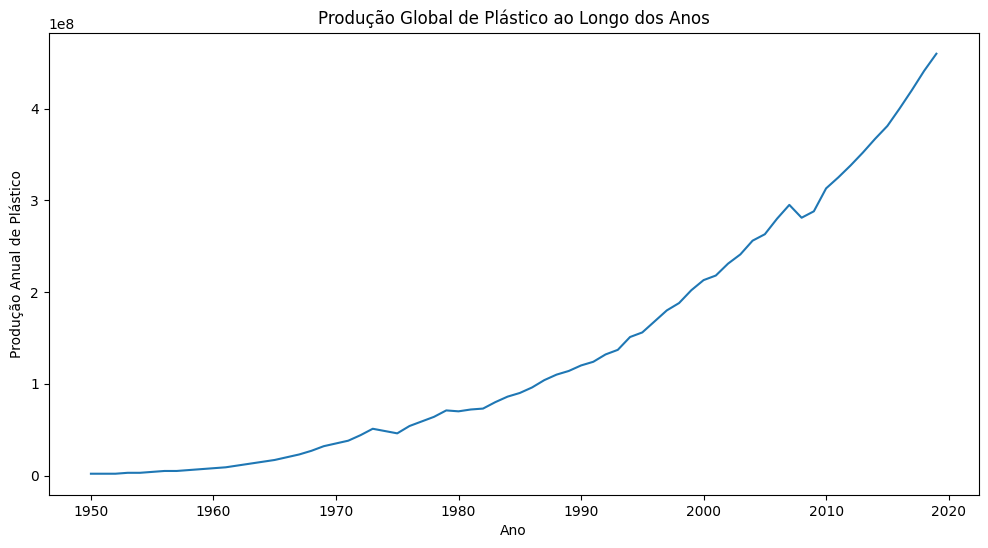

In [5]:
# Extrair os dados relevantes do DataFrame
anos = df1['Ano']
producao = df1['Produção-Anual-de-Plástico']

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(anos, producao)

# Adicionar rótulos e título
plt.xlabel('Ano')
plt.ylabel('Produção Anual de Plástico')
plt.title('Produção Global de Plástico ao Longo dos Anos')

# Exibir o gráfico
plt.show()

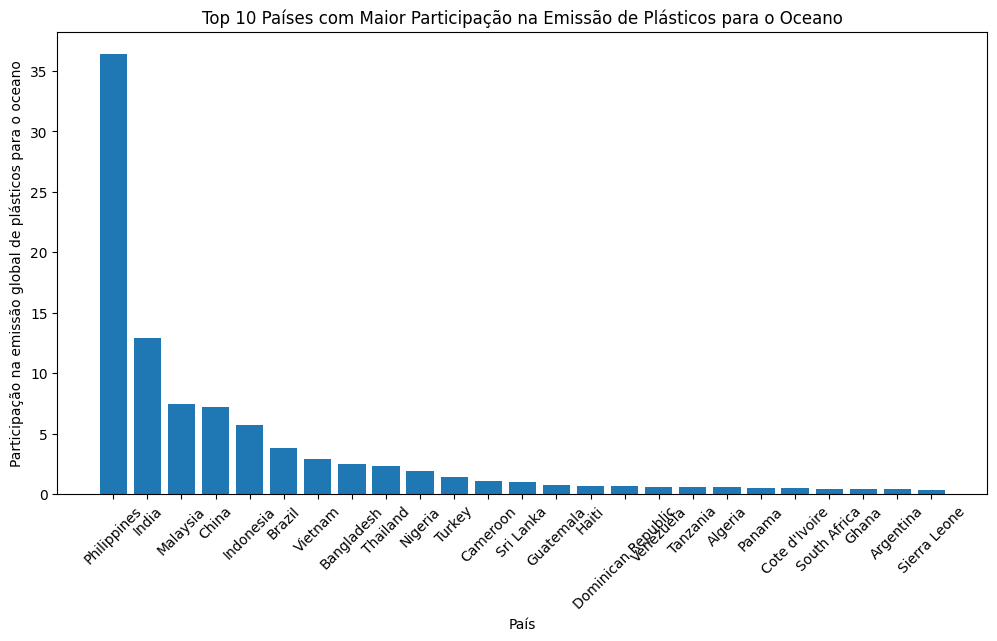

In [6]:

# Ordenar os países por participação na emissão global de plásticos para o oceano
df2_sorted = df2.sort_values('Participação na emissão global de plásticos para o oceano', ascending=False)

# Selecionar os 10 primeiros países
top_10_countries = df2_sorted.head(25)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_10_countries['Entidade'], top_10_countries['Participação na emissão global de plásticos para o oceano'])
plt.xlabel('País')
plt.ylabel('Participação na emissão global de plásticos para o oceano')
plt.title('Top 10 Países com Maior Participação na Emissão de Plásticos para o Oceano')
plt.xticks(rotation=45)
plt.show()

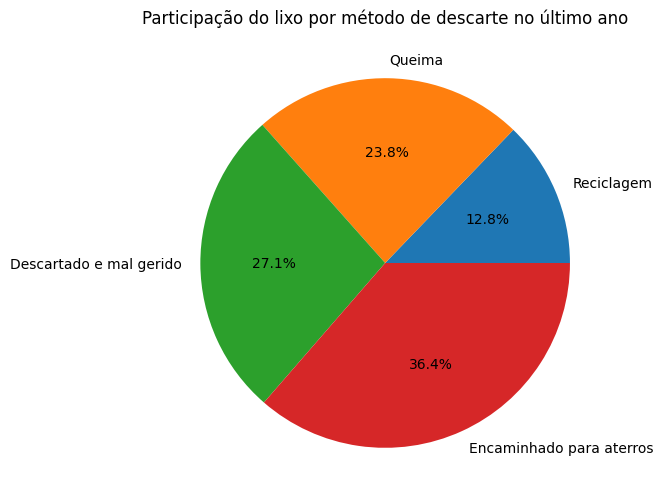

In [7]:
# Selecionando os dados do último ano
last_year_data = df3[df3['Ano'] == df3['Ano'].max()]

# Valores para o gráfico de pizza
values = [last_year_data['Participação da reciclagem do lixo total regional'].values[0], 
          last_year_data['Participação da queima do lixo total regional'].values[0], 
          last_year_data['Participação do lixo descartado e mal gerido do total regional'].values[0], 
          last_year_data['Participação do lixo encaminhado para aterros do total regional'].values[0]]

# Rótulos para o gráfico de pizza
labels = ['Reciclagem', 'Queima', 'Descartado e mal gerido', 'Encaminhado para aterros']

# Criação do gráfico de pizza
plt.figure(figsize=(10, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Participação do lixo por método de descarte no último ano')

plt.show()

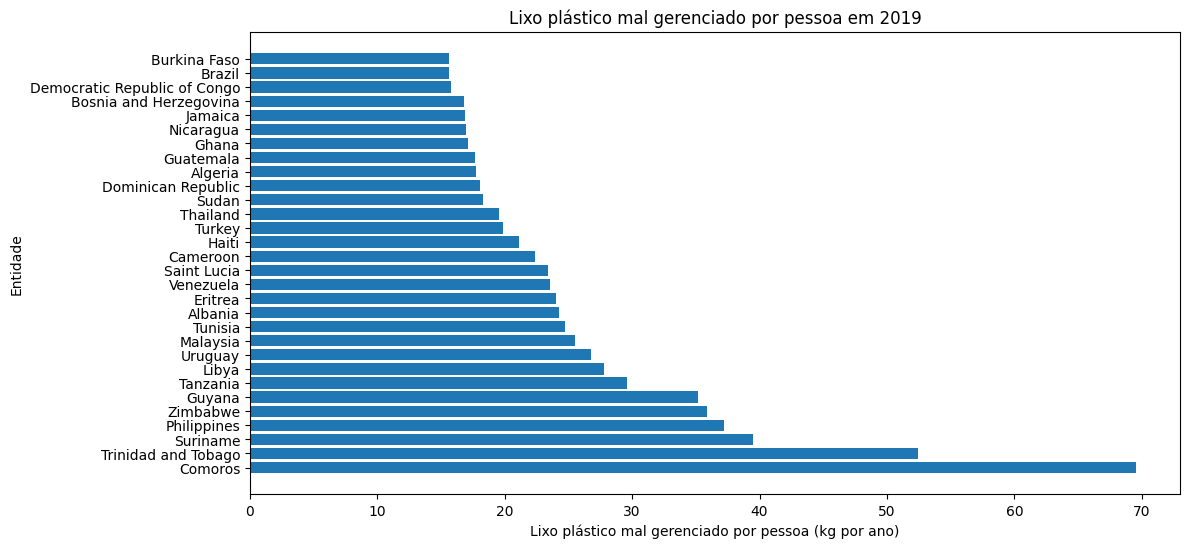

In [8]:
# Selecionando os dados do último ano
last_year = df4['Ano'].max()
data_last_year = df4[df4['Ano'] == last_year]

# Ordenando os dados e selecionando os 10 principais
data_last_year = data_last_year.sort_values('Lixo plástico mal gerenciado por pessoa (kg por ano)', ascending=False).head(30)

# Plotando os dados
plt.figure(figsize=(12, 6))
plt.barh(data_last_year['Entidade'], data_last_year['Lixo plástico mal gerenciado por pessoa (kg por ano)'])
plt.xlabel('Lixo plástico mal gerenciado por pessoa (kg por ano)')
plt.ylabel('Entidade')
plt.title(f'Lixo plástico mal gerenciado por pessoa em {last_year}')

plt.show()

In [9]:
# Combinando os arquivos
df_merged = df1.merge(df2, on='Entidade', how='outer', suffixes=('', '_df2'))
df_merged = df_merged.merge(df3, on='Entidade', how='outer', suffixes=('', '_df3'))
df_merged = df_merged.merge(df4, on='Entidade', how='outer', suffixes=('', '_df4'))
df_merged = df_merged.merge(df5, on='Entidade', how='outer', suffixes=('', '_df5'))

In [10]:
from sklearn.impute import SimpleImputer

# Separar as colunas numéricas e não numéricas
num_cols = df_merged.select_dtypes(include=['float64', 'int64']).columns
non_num_cols = df_merged.select_dtypes(include=['object']).columns

# Imputar os valores faltantes nas colunas numéricas com a média
imputer_num = SimpleImputer(strategy='mean')
df_merged[num_cols] = imputer_num.fit_transform(df_merged[num_cols])

# Imputar os valores faltantes nas colunas não numéricas com a moda
imputer_non_num = SimpleImputer(strategy='most_frequent')
df_merged[non_num_cols] = imputer_non_num.fit_transform(df_merged[non_num_cols])

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [12]:

# Definir as características (X) e o alvo (y)
features = ['Entidade', 'Ano', 'Produção-Anual-de-Plástico', 
            'Participação na emissão global de plásticos para o oceano',
            'Participação da reciclagem do lixo total regional',
            'Participação da queima do lixo total regional',
            'Participação do lixo descartado e mal gerido do total regional',
            'Participação do lixo encaminhado para aterros do total regional',
            'Lixo plástico mal gerenciado por pessoa (kg por ano)', 'Cidade', 'Região', 'Qualidade do Ar']

In [13]:

target = ['Poluição da Água']

X = df_merged[features]
y = df_merged[target]

In [14]:
# Definir as colunas categóricas e numéricas
categorical_features = ['Entidade', 'Cidade', 'Região']
numeric_features = [col for col in features if col not in categorical_features]

In [15]:
# Definir o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [16]:

# Definir o pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

In [17]:

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões de teste
y_pred = pipeline.predict(X_test)

In [19]:
# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 19.32248340930854
